## Recipe 30 - Perfoming Feature hashing 

In [58]:
import pandas as pd
import seaborn as sns

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding using feature-engine
from category_encoders import HashingEncoder

In [59]:
data = pd.read_csv('creditApprovalUCI.csv')

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [60]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,  # predictors
    data['A16'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((483, 16), (207, 16))

In [61]:
# There should bea check for high cardinality here - just in case it does not fit in 8 bits 

X_train['A7'].unique()

array(['v', 'ff', 'h', 'dd', 'z', 'bb', 'j', 'Missing', 'n', 'o'],
      dtype=object)

In [62]:
# create the feature hashing encoder

encoder = HashingEncoder(cols=['A7'], n_components=4)

In [63]:
# fit the transformer to the train set

encoder.fit(X_train)

HashingEncoder(cols=['A7'], max_process=2, max_sample=241, n_components=4)

In [64]:
# let's inspect the hashing method

encoder.hash_method

'md5'

In [65]:
# let's transform train and test sets

X_train_enc = encoder.transform(X_train)
X_test_enc = encoder.transform(X_test)

In [66]:
print(X_train_enc.head())

     col_0  col_1  col_2  col_3 A1     A2     A3 A4 A5  A6      A8 A9 A10  \
596      0      0      1      0  a  46.08  3.000  u  g   c   2.375  t   t   
303      0      0      1      0  a  15.92  2.875  u  g   q   0.085  f   f   
204      0      0      1      0  b  36.33  2.125  y  p   w   0.085  t   t   
351      0      1      0      0  b  22.17  0.585  y  p  ff   0.000  f   f   
118      0      0      1      0  b  57.83  7.040  u  g   m  14.000  t   t   

     A11 A12 A13    A14   A15  A16  
596    8   t   g  396.0  4159    1  
303    0   f   g  120.0     0    0  
204    1   f   g   50.0  1187    1  
351    0   f   g  100.0     0    0  
118    6   t   g  360.0  1332    1  


In [67]:
X_test_enc.head()

,col_0,col_1,col_2,col_3,A1,A2,A3,A4,A5,A6,A8,A9,A10,A11,A12,A13,A14,A15,A16
14,0,0,1,0,a,45.83,10.50,u,g,q,5.000,t,t,7,t,g,0.0,0,1
586,0,1,0,0,b,64.08,20.00,u,g,x,17.500,t,t,9,t,g,0.0,1000,1
140,0,1,0,0,a,31.25,3.75,u,g,cc,0.625,t,t,9,t,g,181.0,0,1
492,0,0,1,0,b,39.25,9.50,u,g,m,6.500,t,t,14,f,g,240.0,4607,1
350,0,1,0,0,a,26.17,2.00,u,g,j,0.000,f,f,0,t,g,276.0,1,0


## Recipe 31 -Begin Numerical Variable Transformations - log transformations 

In [68]:
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# for Q-Q plots
import scipy.stats as stats

# the dataset for the demo
from sklearn.datasets import load_boston

# with open-source packages
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split

from feature_engine import transformation as vt

# from feature_engine.variable_transformers import LogTransformer

In [69]:
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


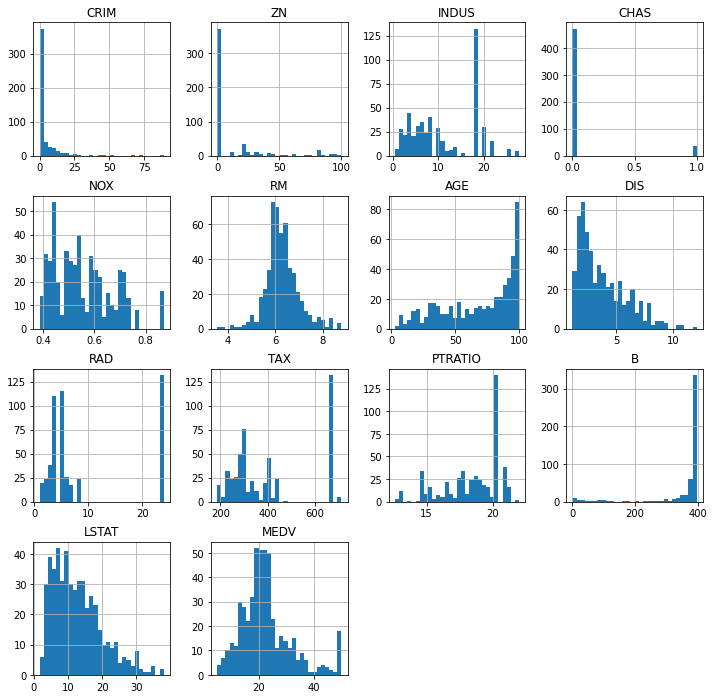

In [70]:
# plot the histogram to inspect variable distributions (not in book)

data.hist(bins=30, figsize=(12,12))
plt.show()

In [71]:
# plot histogram and Q-Q plots to have a look at the variable distribution

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

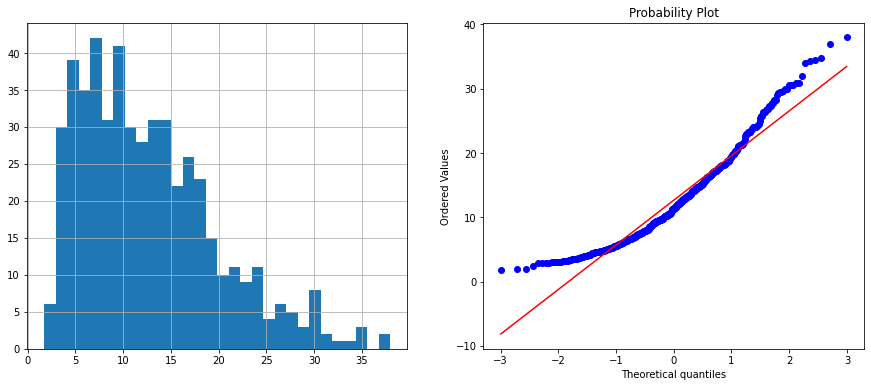

In [72]:
# check original distribution

diagnostic_plots(data, 'LSTAT')

## Logarithmic transformation with numpy

In [73]:
# make a copy of the dataframe where we will store the modified
# variables

data_tf = data.copy()

In [74]:
# apply log to a set of variables
data_tf[['LSTAT', 'NOX', 'DIS', 'RM']] = np.log(
    data[['LSTAT', 'NOX', 'DIS', 'RM']])

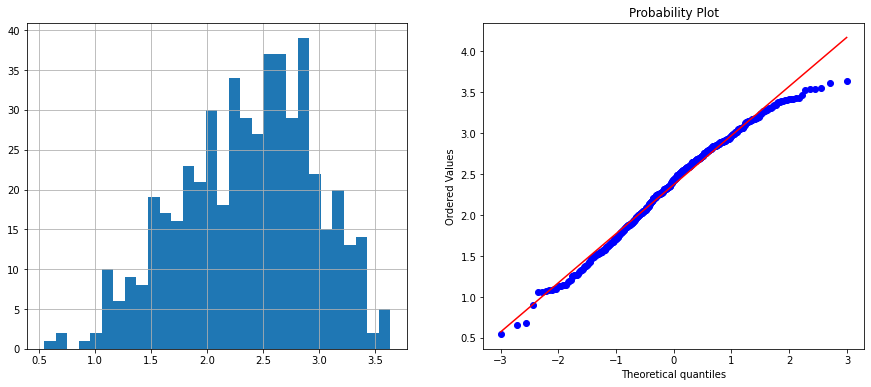

In [75]:
# use diagnostic plot function to address variable transformation

diagnostic_plots(data_tf, 'LSTAT')

## Logarithmic transformation with scikit learn

In [76]:
# start the transformer with NumPy log as argument
transformer = FunctionTransformer(np.log, validate=True)

In [77]:
# make a list of columns to transform
cols = ['LSTAT', 'NOX', 'DIS', 'RM']

# transform subset of dataframe
data_tf = transformer.transform(data[cols])

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [78]:
# capture returned NumPy array in pandas dataframe
data_tf = pd.DataFrame(data_tf, columns=cols)

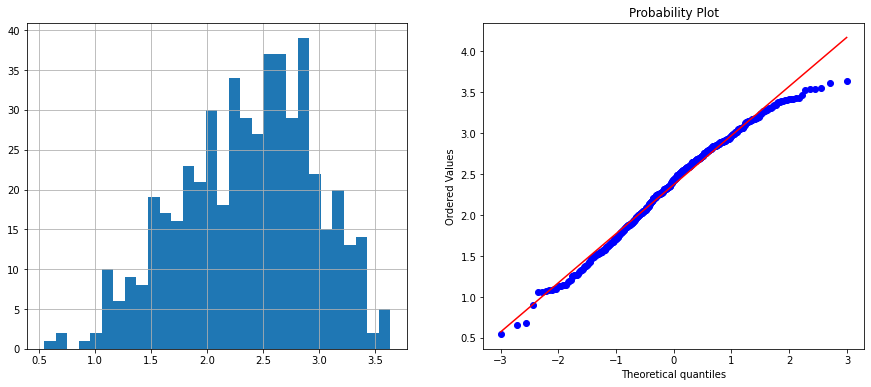

In [79]:
# use diagnostic plot function to evaluate transformation
# (not in book)
diagnostic_plots(data_tf, 'LSTAT')

## Logarithmic transformation with Feature-engine

In [80]:
# initialize the transformer

lt = vt.LogTransformer(variables=['LSTAT', 'NOX', 'DIS', 'RM'])

# fit transformer to data set
lt.fit(data)

LogTransformer(variables=['LSTAT', 'NOX', 'DIS', 'RM'])

In [81]:
# transform variables within our data set
data_tf = lt.transform(data)

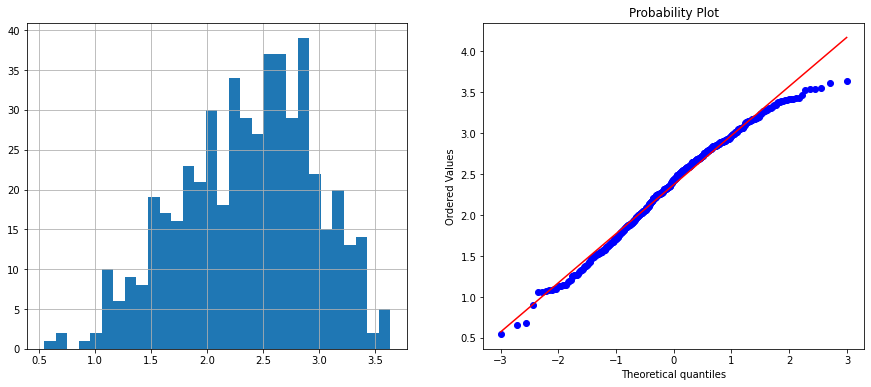

In [82]:
# use diagnostic plot function to evaluate transformation
# (not in book)

diagnostic_plots(data_tf, 'LSTAT')

## Logarithm with Scikit-learn selecting a group of variables

### Not in book

In [83]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [84]:
# boston.csv in local file 
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [85]:
# list of variables to transform
cols = ['LSTAT', 'NOX', 'DIS', 'RM']

# set transformer within a pipeline
log_transformer = Pipeline(steps=[('log_transformer',
                                   FunctionTransformer(np.log, validate=True))])

# set pipeline within ColumnTransformer to select features
preprocessor = ColumnTransformer(transformers=[
    ('log_transformer', log_transformer, cols)], remainder='passthrough')

In [86]:
# fit to the data (the entire dataframe this time)
preprocessor.fit(data)

# transform the data - note this returns a numpy array
data_tf = preprocessor.transform(data)

In [87]:
# visualize the data as a pandas dataframe
pd.DataFrame(data_tf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.605430,-0.619897,1.408545,1.883275,0.00632,18.0,2.31,0.0,65.2,1.0,296.0,15.3,396.90,24.0
1,2.212660,-0.757153,1.602836,1.859574,0.02731,0.0,7.07,0.0,78.9,2.0,242.0,17.8,396.90,21.6
2,1.393766,-0.757153,1.602836,1.971996,0.02729,0.0,7.07,0.0,61.1,2.0,242.0,17.8,392.83,34.7
3,1.078410,-0.780886,1.802073,1.945624,0.03237,0.0,2.18,0.0,45.8,3.0,222.0,18.7,394.63,33.4
4,1.673351,-0.780886,1.802073,1.966693,0.06905,0.0,2.18,0.0,54.2,3.0,222.0,18.7,396.90,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2.269028,-0.556870,0.907694,1.886008,0.06263,0.0,11.93,0.0,69.1,1.0,273.0,21.0,391.99,22.4
502,2.206074,-0.556870,0.827460,1.811562,0.04527,0.0,11.93,0.0,76.7,1.0,273.0,21.0,396.90,20.6
503,1.729884,-0.556870,0.773574,1.942476,0.06076,0.0,11.93,0.0,91.0,1.0,273.0,21.0,396.90,23.9
504,1.868721,-0.556870,0.870833,1.916040,0.10959,0.0,11.93,0.0,89.3,1.0,273.0,21.0,393.45,22.0


## Recipe 32 - Reciprocal transformations 

In [88]:
# with open-source packages
from sklearn.preprocessing import FunctionTransformer

from feature_engine import transformation as vt
# from feature_engine.variable_transformers import ReciprocalTransformer

In [89]:
# boston.csv in local file 
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


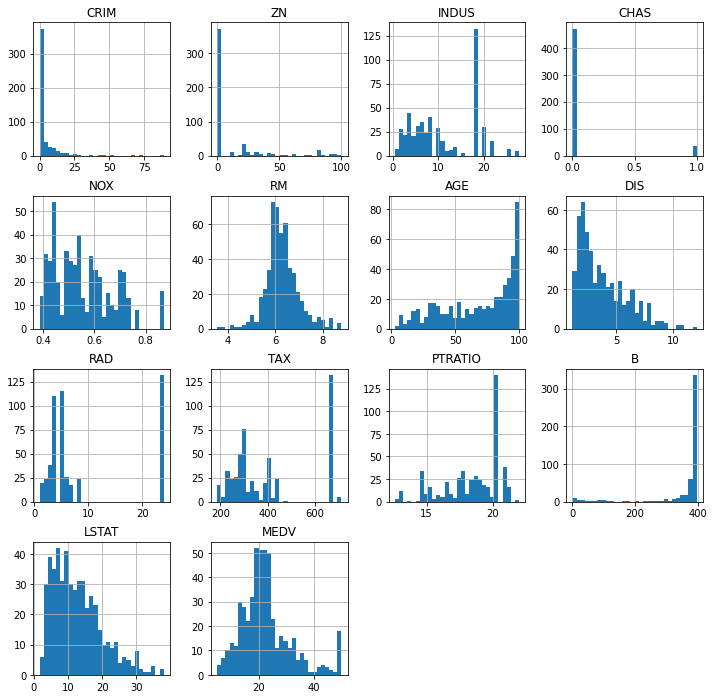

In [90]:
# plot the histogram to inspect variable distributions (not in book)

data.hist(bins=30, figsize=(12,12))
plt.show()

In [93]:
# plot histogram and Q-Q plots to have a look at the variable distribution

def diagnostic_plots_with_kde(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 3, 1)
# df[variable].hist(bins=30)
    sns.histplot(df[variable], bins=30, kde=True)

    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    
    plt.subplot(1, 3, 3)
    df[variable].plot.kde()


    plt.show()

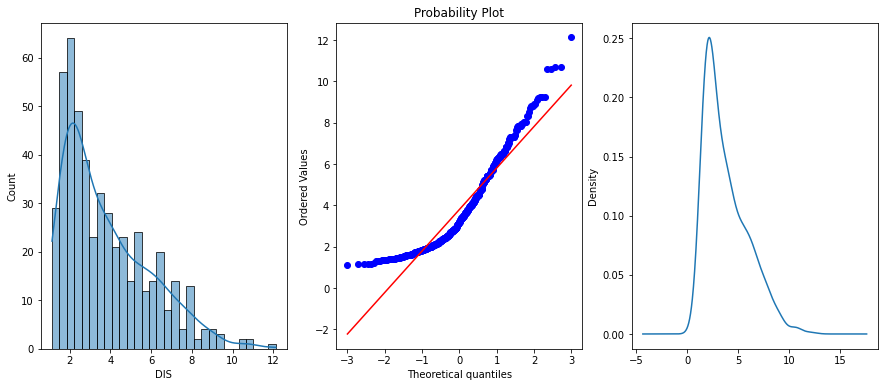

In [94]:
# check original distribution of the variable DIS

diagnostic_plots_with_kde(data, 'DIS')

## Reciprocal transformation with NumPy

In [95]:
# make a copy of the dataframe where we will store the modified
# variables

data_tf = data.copy()

In [96]:
# apply the reciprocal to a set of variables

data_tf[['LSTAT', 'NOX', 'DIS', 'RM']] = np.reciprocal(data[['LSTAT', 'NOX', 'DIS', 'RM']])

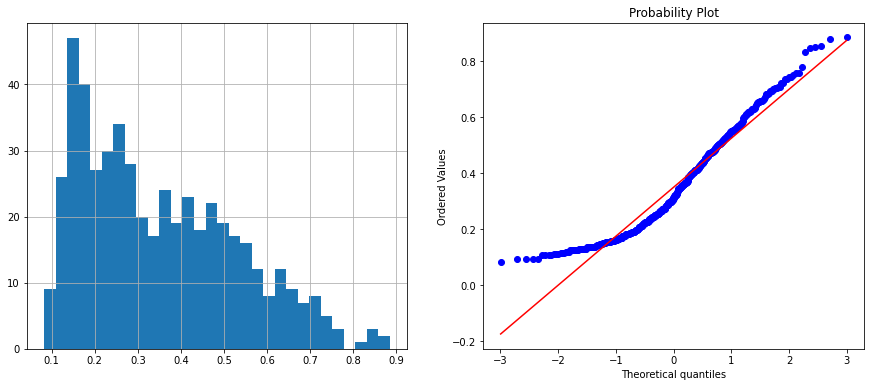

In [97]:
# use diagnostic plot function to address variable transformation

diagnostic_plots(data_tf, 'DIS')

## Reciprocal transformation with Scikit-learn

In [98]:
# start the transformer with NumPy reciprocal as argument

transformer = FunctionTransformer(np.reciprocal, validate=True)

In [99]:
# make a list of columns to transform
cols = ['LSTAT', 'NOX', 'DIS', 'RM']

# transform subset of dataframe
data_tf = transformer.transform(data[cols])

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [100]:
# capture returned NumPy array in pandas dataframe

data_tf = pd.DataFrame(data_tf, columns=cols)

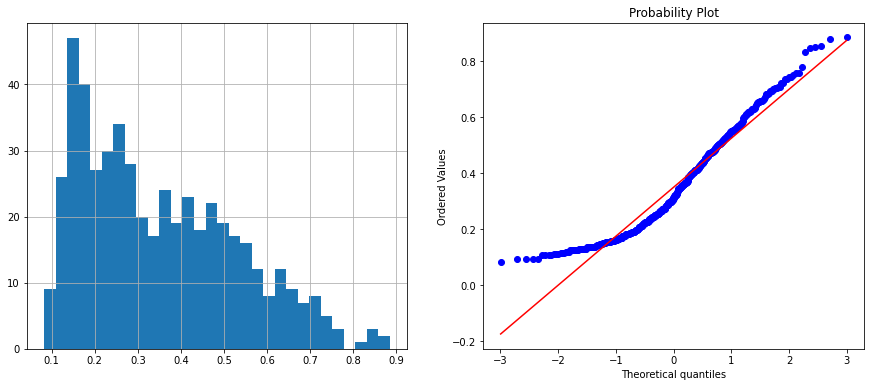

In [101]:
# use diagnostic plot function to evaluate transformation
# (not in book)

diagnostic_plots(data_tf, 'DIS')

## Reciprocal transformation with Feature-engine

In [102]:
# initialize the transformer
rt = vt.ReciprocalTransformer(variables = ['LSTAT', 'NOX', 'DIS', 'RM'])

# fit transformer to the entire dataframe
rt.fit(data)

ReciprocalTransformer(variables=['LSTAT', 'NOX', 'DIS', 'RM'])

In [103]:
# transform the indicated variables within our data set
data_tf = rt.transform(data)

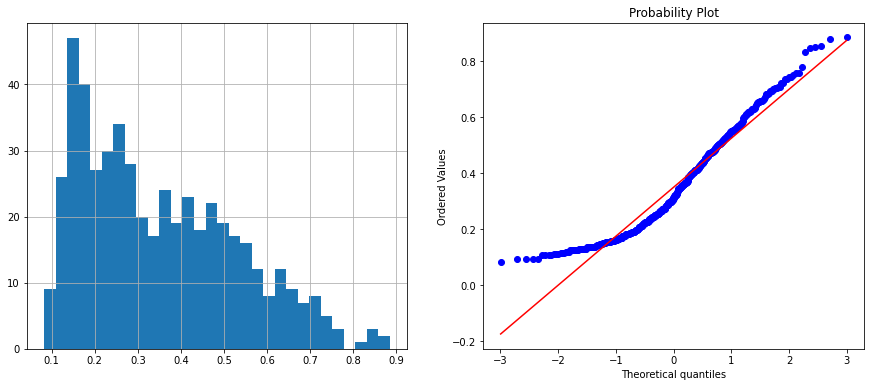

In [104]:
# use diagnostic plot function to evaluate transformation
# (not in book)

diagnostic_plots(data_tf, 'DIS')

## Recipe 33 - Using square & cube roots to transform variables

In [105]:
# with open-source packages
from sklearn.preprocessing import FunctionTransformer

In [106]:
# boston.csv in local file 
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


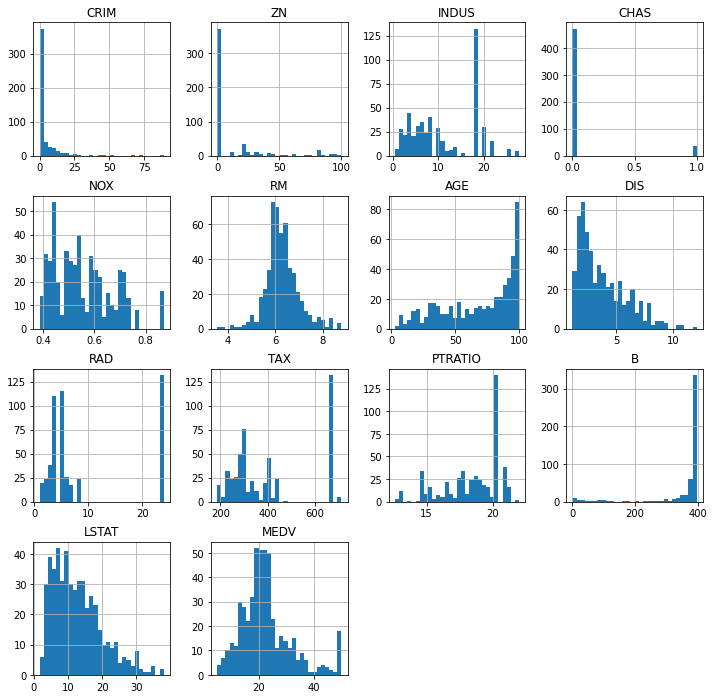

In [107]:
# plot the histogram to inspect variable distributions (not in book)

data.hist(bins=30, figsize=(12,12))
plt.show()

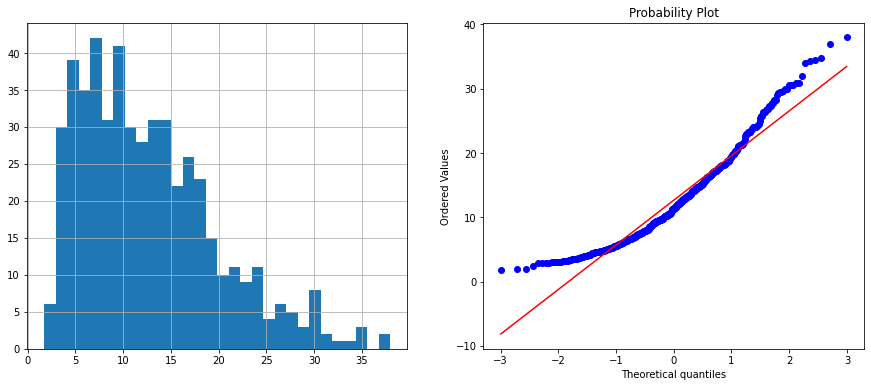

In [108]:
# check original distribution (not in book recipe)

diagnostic_plots(data, 'LSTAT')

## Square / Cube root transformation with NumPy

In [ ]:
# make a copy of the dataframe where we will store the modified
# variables

data_tf = data.copy()

In [109]:
# apply the square root transformation to a set of variables
data_tf[['LSTAT', 'NOX', 'DIS', 'RM']] = np.sqrt(data[['LSTAT', 'NOX', 'DIS', 'RM']])

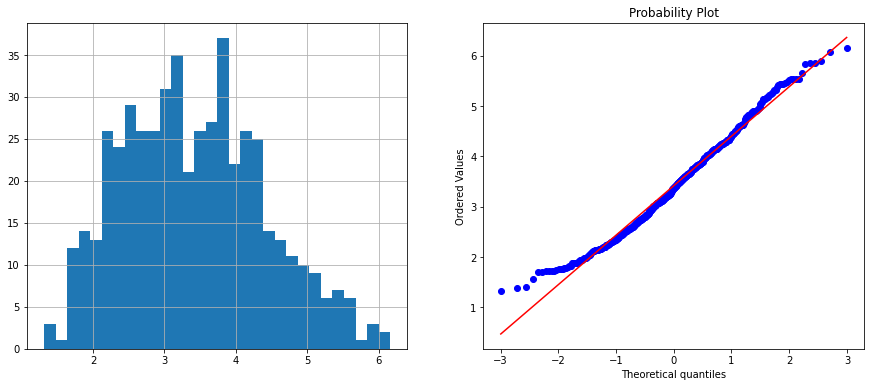

In [110]:
# plot to visualize the transformation (not in book)

diagnostic_plots(data_tf, 'LSTAT')

In [111]:
# apply the cube root transformation to a set of variables

data_tf[['LSTAT', 'NOX', 'DIS', 'RM']] = np.cbrt(data[['LSTAT', 'NOX', 'DIS', 'RM']])

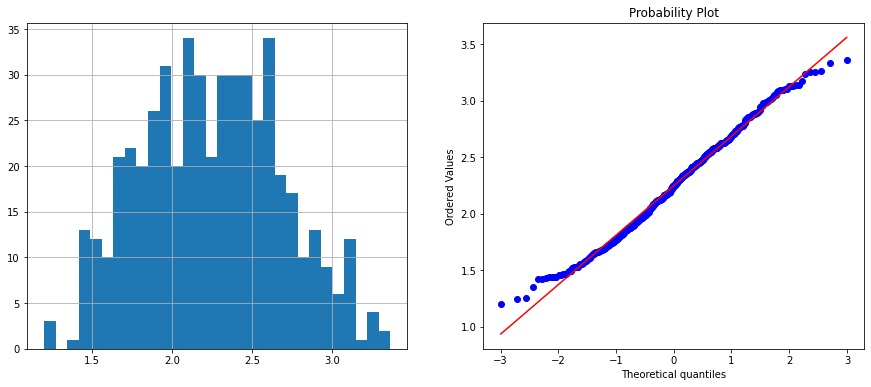

In [112]:
# plot to visualize the transformation (not in book)

diagnostic_plots(data_tf, 'LSTAT')

## Square / Cube root transformation with Scikit-learn

In [113]:
# start the transformer with NumPy sqrt as argument

transformer = FunctionTransformer(np.sqrt, validate=True)

In [114]:
# make a list of variables to transform
cols = ['LSTAT', 'NOX', 'DIS', 'RM']

# transform slice of dataframe with indicated variables
# returns NumPy array
data_tf = transformer.transform(data[cols])

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [115]:
# capture NumPy array into dataframe (not in book) 
data_tf = pd.DataFrame(data_tf, columns=cols)

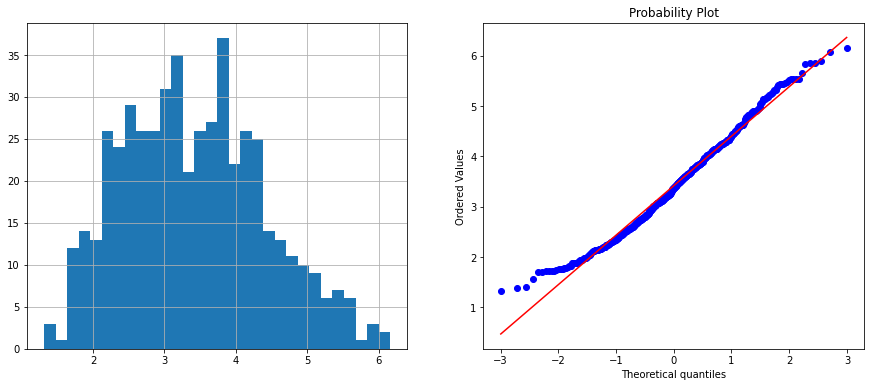

In [116]:
#make plot to visualize transformation (not included in book)
diagnostic_plots(data_tf, 'LSTAT')

## There is more...

### Only summarized in book, code not present

Apply Square and cube root with Feature-engine

In [117]:
from feature_engine import transformation as vt


In [118]:
# set up PowerTransformer with the square root exponent
et = vt.PowerTransformer(variables = ['LSTAT', 'NOX', 'DIS', 'RM'], exp=1/3) # for cube root

# fit transformer to data 
et.fit(data)

PowerTransformer(exp=0.3333333333333333,
                 variables=['LSTAT', 'NOX', 'DIS', 'RM'])

In [119]:
# transform indicated variables within our dataframe
data_tf = et.transform(data)

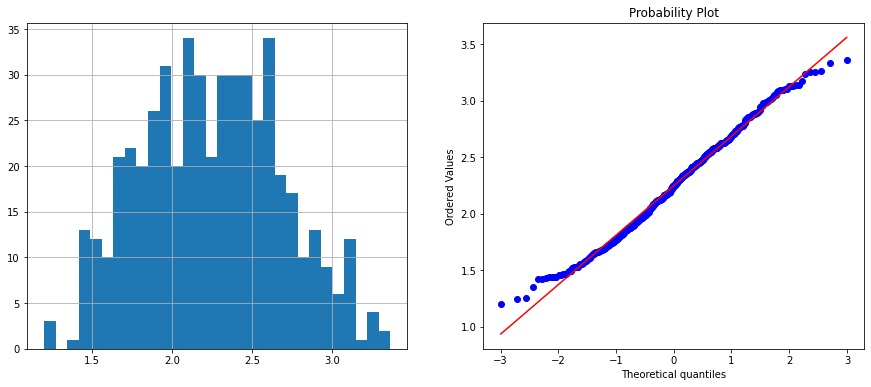

In [120]:
# visualize the trasnformation

diagnostic_plots(data_tf, 'LSTAT')

## recipe 34 - power transformer

In [121]:
# boston.csv in local file 
data = pd.read_csv('boston.csv')
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


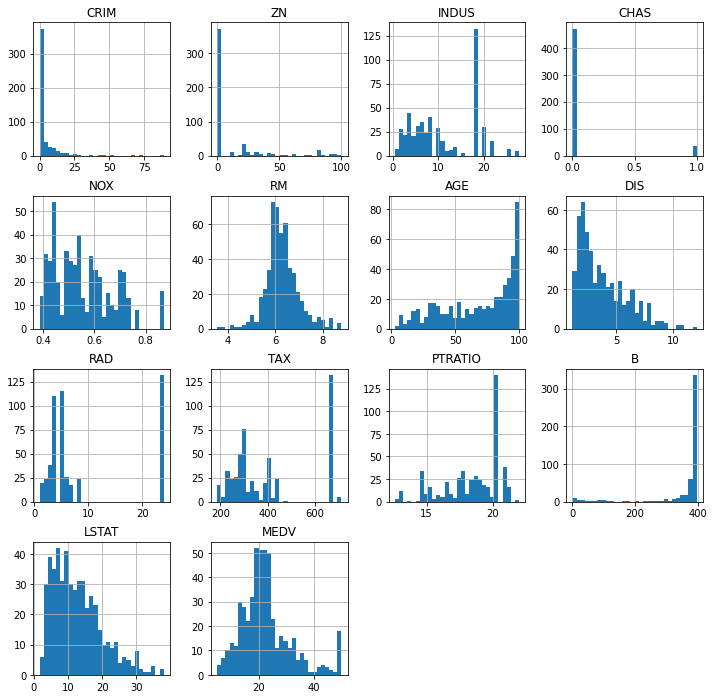

In [122]:
# plot the histogram to inspect variable distributions (not in book)

data.hist(bins=30, figsize=(12,12))
plt.show()

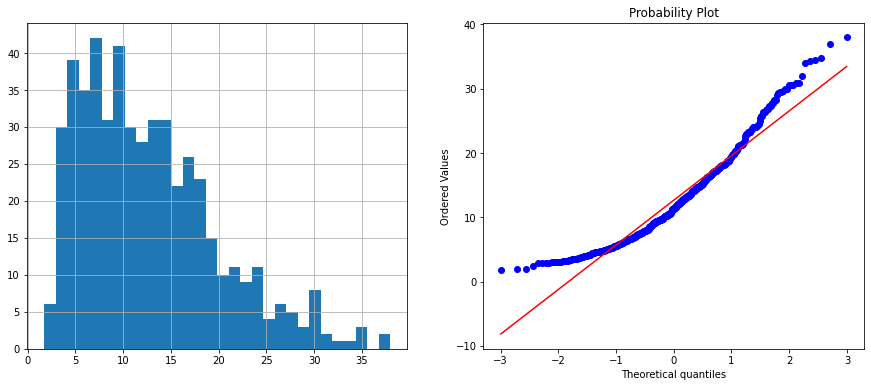

In [123]:
# check original distribution (not included in this recipe of book)

diagnostic_plots(data, 'LSTAT')

In [125]:
## Exponential transformation with NumPy

In [126]:
# make a copy of the dataframe where we will store the modified
# variables

data_tf = data.copy()

In [127]:
# apply a 0.3 exponent power transformation to a set of variables

data_tf[['LSTAT', 'NOX', 'DIS', 'RM']] = np.power(data[['LSTAT', 'NOX', 'DIS', 'RM']], 0.3)

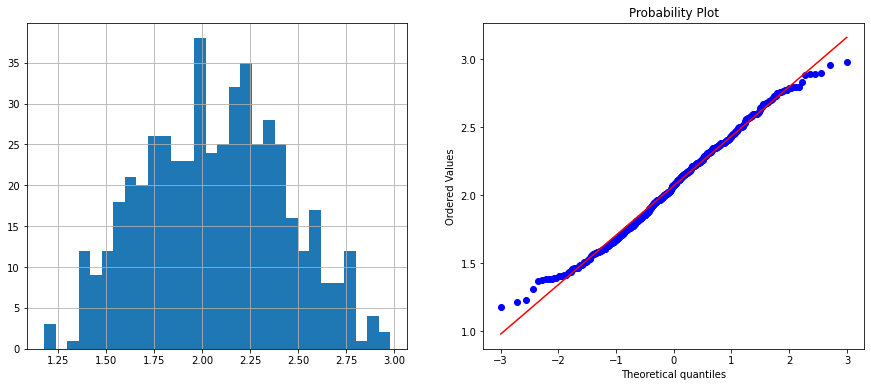

In [128]:
# visuallize the transformation (not included in recipe)

diagnostic_plots(data_tf, 'LSTAT')

## Exponential transformation with Scikit-learn

In [129]:
# initialize the transformer with a user defined function, in this
# case the 0.3 power transformation

transformer = FunctionTransformer(lambda x: np.power(x, 0.3), validate=True)

In [130]:
# capture variables to transform in a list
cols = ['LSTAT', 'NOX', 'DIS', 'RM']

# transform slice of dataframe with indicated variables
data_tf = transformer.transform(data[cols])

c:\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [131]:
# capture returned NumPy array into a dataframe

data_tf = pd.DataFrame(data_tf, columns=cols)

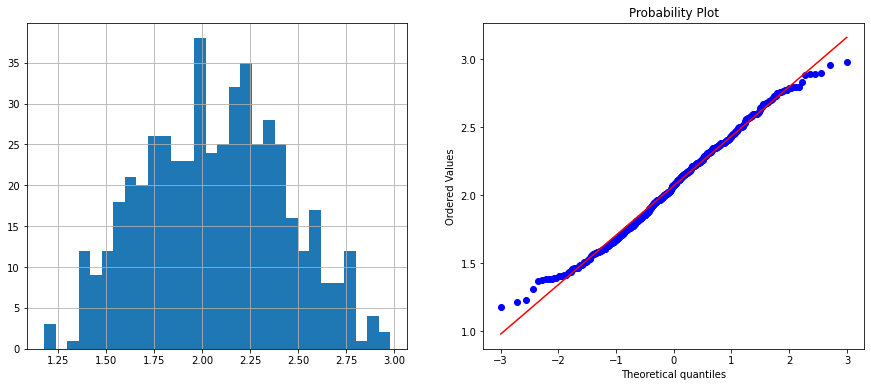

In [132]:
# visualize the transformation (not in book)
diagnostic_plots(data_tf, 'LSTAT')

## Exponential transformation with Feature-engine

In [133]:
# initialize the transformer with the variables to transform and 
# the desired exponent

et = vt.PowerTransformer(variables = ['LSTAT', 'NOX', 'DIS', 'RM'], exp=0.3)

# fit transformer to data
et.fit(data)

PowerTransformer(exp=0.3, variables=['LSTAT', 'NOX', 'DIS', 'RM'])

In [134]:
# transform indicated variables in the dataset
data_tf = et.transform(data)

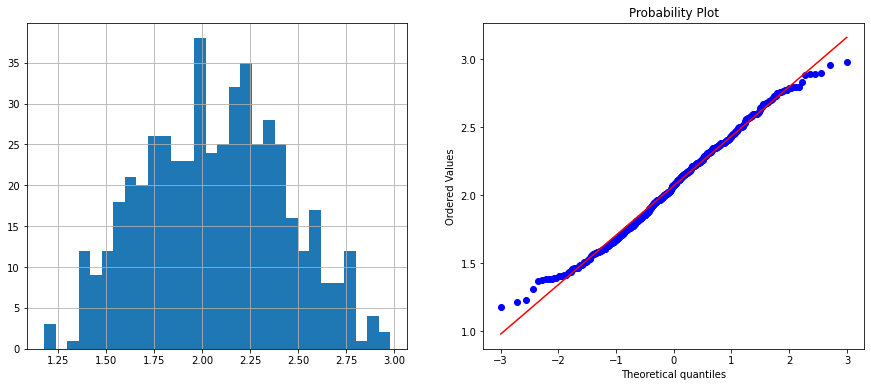

In [135]:
# plot transform variable
diagnostic_plots(data_tf, 'LSTAT')

## There is more
### Not included in the book

Apply different power transformations to different set of features using Feature-engine

In [137]:
from sklearn.pipeline import Pipeline

In [138]:
pipe = Pipeline([
    ('power1', vt.PowerTransformer(variables = ['LSTAT', 'NOX'], exp=0.3)),    
    ('power2', vt.PowerTransformer(variables = ['DIS'], exp=0.4)),
    ('power3', vt.PowerTransformer(variables = ['RM'], exp=0.5)),
     ])

In [139]:
pipe.fit(data)

Pipeline(steps=[('power1',
                 PowerTransformer(exp=0.3, variables=['LSTAT', 'NOX'])),
                ('power2', PowerTransformer(exp=0.4, variables=['DIS'])),
                ('power3', PowerTransformer(variables=['RM']))])

In [140]:
data_tf = pipe.transform(data)